# DCGAN

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import time
from IPython import display
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Reshape, Flatten
from tqdm import tqdm

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
init = RandomNormal(mean=.0, stddev=.02)

%matplotlib inline
print(tf.__version__)

2.12.0


In [2]:
#@title (вспомогательный код -- выполните клетку)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(discr_pred_fake_data):
    """
    discr_pred_fake_data -- предсказания дискриминатора на фейковых данных
    """
    labels = tf.ones_like(discr_pred_fake_data)
    # для генератора "хорошо", 
    # когда фейковые данные дискриминатор назвал реальными
    return cross_entropy(labels, discr_pred_fake_data) 

def discriminator_loss(disc_pred_real_data, disc_pred_fake_data):
    """
    disc_pred_real_data -- логиты, предсказанные дискриминатором для реальных данных
    disc_pred_fake_data -- логиты, предсказанные дискриминатором для фейковых данных
    """
    real_labels = tf.ones_like(disc_pred_real_data) # правильные ответ для реальных данных -- 1
    fake_labels = tf.zeros_like(disc_pred_fake_data) # правильные ответ для фейковых данных -- 0
    
    real_loss = cross_entropy(real_labels, disc_pred_real_data)
    fake_loss = cross_entropy(fake_labels, disc_pred_fake_data)

    total_loss = real_loss + fake_loss
    return total_loss

def generate_latent_points(latent_dim, n):
	x_input = np.random.randn(n,  latent_dim)
	return x_input

def generate_fake_samples(generator, n):
    x_input = generate_latent_points(generator.input_shape[1], n)
    X = generator.predict(x_input)
    return X

def show_result(generator, title=""):
    X_fake = generate_fake_samples(generator=generator, n=100)
    X_real = generate_real_samples(n=100)  
    plt.figure()
    plt.title(title)
    plt.scatter(X_real[:, 0], X_real[:, 1], label="real samples")
    plt.scatter(X_fake[:, 0], X_fake[:, 1], label="generated samples")
    plt.legend(loc="best")
    plt.show()

def train_step(discriminator, generator, optimizer, batch_size=128):
    half_batch = int(batch_size / 2)	
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 1. Сэмплируем batch_size/2 точек из реального распределения
        X_real = generate_real_samples(n=half_batch)
        
        # генератор генерирует данные из латентных векторов, которые принадлежат простому распределению
        # и учится превращать их в распределени которое сможет обмануть дискриминатор
        # сначала генерируем латентные вектора -- 
        latent_z = np.random.randn(half_batch,  generator.input_shape[1])
        # а затем превращаем их с помощью генератора в X_fake
        X_fake = generator(latent_z)
        
        # 3. Делаем forward_pass дискриминатора на x_real и x_fake, 
        # получив discr_pred_real_data и discr_pred_fake_data
        discr_pred_real_data = discriminator(X_real)
        discr_pred_fake_data = discriminator(X_fake)

        # 4. Посчитать лосс дискриминатора и генератора
        disc_loss = discriminator_loss(discr_pred_real_data, discr_pred_fake_data)
        gen_loss = generator_loss(discr_pred_fake_data)
    
    # считаем производные
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # 5. Обновляем параметры генератора и дискриминатора. 
    optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return disc_loss.numpy(), gen_loss.numpy()

def train_gan(discriminator, generator, optimizer, n_epochs=10000, n_batch=128,
              show_every=1000):
    losses_hist_disc = []
    losses_hist_gen = []
    for i in tqdm(range(n_epochs)):
        if i % show_every == 0:
            show_result(generator=generator, title=f"Epoch {i}")
            
        disc_loss, gen_loss = train_step(discriminator, generator, optimizer, n_batch)
        losses_hist_disc.append(disc_loss)
        losses_hist_gen.append(gen_loss)
    return losses_hist_disc, losses_hist_gen

In [13]:
class DCGAN(tf.keras.Model):
    
    def __init__(self, image_size, output_path, num_channels=1, z_dim=128,
                 G_h_size=128, D_h_size=128, batch_size=256):
        super().__init__()
        self.image_size = image_size
        self.num_channels = num_channels
        self.z_dim = z_dim
        
        self.output_path = output_path
        self.G_h_size = G_h_size
        self.D_h_size = D_h_size
        
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        
        self.optimizer = tf.keras.optimizers.legacy.Adam(.0002, beta_1=.5, beta_2=.999)
        
        self.batch_size = batch_size
        self._vis_h = 5
        self._vis_w = 5
        self._vis_noise = np.random.normal(0, 1, (self._vis_h* self._vis_w, self.z_dim)).astype(np.float32)
        
    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def generator_loss(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def _conv_bn_leaky(self, kernel_size, channels, stride=1):
        """
        Блок содержит Conv + BatchNorm + LeakyRelu
        При указании stride=2 -- уменьшит размер в два раза.
        """
        model = tf.keras.Sequential()
        model.add(Conv2D(channels, 
                         kernel_size=kernel_size, padding='same',
                         use_bias=False, kernel_initializer=init,
                         strides=(stride, stride))) # use_bias=False, т.к. BatchNorm и так вычтет среднее
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        return model
    
    def _build_generator(self):
        """
        Генератор должен превращать вектор длины self.z_dim в картинку 32x32x1
        """
        model = tf.keras.Sequential()
        # для начала сделаем вектор -- трехмерным тензором с помощью Reshape
        model.add(Reshape((1, 1, self.z_dim), input_shape=(self.z_dim,)))
        
        # Превратим его в тензор размера (4, 4, self.G_h_size * 4)
        model.add(Conv2DTranspose(self.G_h_size * 4, 
                                  kernel_size = 4, use_bias=False,
                                  kernel_initializer = init))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        
        upsamples_num = int(np.log2(self.image_size / 8)) # сколько раз применим в цикле,
                                                          # чтобы из (4,4) получить (image_size/2, image_size/2)
                                                          # в нашем случае -- 2 (image_size=32)
                
        for i in range(upsamples_num):
            model.add(UpSampling2D()) # увеличиваем картинку
            model.add(self._conv_bn_leaky(4, self.G_h_size * 4 // 2**(i+1))) # уменьшаем количество фильтров в два раза
        
        model.add(UpSampling2D())
        model.add(Conv2D(self.num_channels,
                         kernel_size=4, strides=(1, 1),
                         activation='tanh', padding='same',
                         kernel_initializer=init))
        return model
    
    def _build_discriminator(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(
            input_shape=((self.image_size, self.image_size, self.num_channels))))
        model.add(self._conv_bn_leaky(kernel_size=4,
                                      channels=self.D_h_size,
                                      stride=2,))
        
        downsamples_num = int(np.log2(self.image_size / 8)) # столько раз применим даунсэмплинг в цикле чтобы
                                                            # из (image_size/2, image_size/2) получить (4, 4)
        for i in range(downsamples_num):
            model.add(self._conv_bn_leaky(kernel_size=4,
                                          channels=self.D_h_size * (2 ** (i + 1)),
                                          stride=2)) # количество фильтров увеличивается, размер уменьшается
        # после цикла получили тензор размера (4, 4, 256), значит свернув его с ядром (4, 4, 256, 1) -- получим число
        model.add(Conv2D(1, kernel_size=4, kernel_initializer=init)) # без активации!
        model.add(Flatten())
        return model
    
    @tf.function
    def train_step(self, images):
        """
        Шаг обучения
        """
        noise = tf.random.normal([tf.cast(images.shape[0], tf.int32), self.z_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)
            
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
    def save_imgs(self, epoch):
        """
        Сохранение промежуточных картинок на диск
        """
        gen_imgs = self.generator(self._vis_noise, training=False)
        gen_imgs = .5 * gen_imgs + .5
        fig, axs = plt.subplots(self._vis_h, self._vis_w, figsize=(6, 6))
        cnt = 0
        for i in range(self._vis_h):
            for j in range(self._vis_w):
                if self.num_channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(self.output_path / f"mnist_{epoch}.png")
        plt.show()
        
    def train(self, dataset, epochs):
        """
        Цикл обучения
        """
        for epoch in range(epochs):
            start = time.time()
            iters = 0
            for image_batch in tqdm(dataset):
                self.train_step(image_batch)
                iters += 1
                if iters % 100 == 0:
                    display.clear_output(wait=True)
                    self.save_imgs(f"{epoch}:{iters}")
                
            display.clear_output(wait=True)
            self.save_imgs(epoch)
            
            print(f"Time for epoch {epoch} is {time.time() - start} sec")

In [14]:
output = Path("images_mnist3")
output.mkdir(exist_ok=True)
BATCH_SIZE = 256
IMAGE_SIZE = 32
EPOCHS = 20
gan = DCGAN(image_size=IMAGE_SIZE, num_channels=1, output_path=output, z_dim=100, D_h_size=64, G_h_size=64)

/Users/adwiz/miniconda3/envs/tf/lib/python3.8/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [15]:
gan.generator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 4, 4, 256)        409600    
 ranspose)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 4, 4, 256)        1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_3 (UpSampling  (None, 8, 8, 256)        0         
 2D)                                                             
                                                      

In [16]:
gan.discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 16, 16, 64)        1280      
                                                                 
 sequential_12 (Sequential)  (None, 8, 8, 128)         131584    
                                                                 
 sequential_13 (Sequential)  (None, 4, 4, 256)         525312    
                                                                 
 conv2d_13 (Conv2D)          (None, 1, 1, 1)           4097      
                                                                 
 flatten_1 (Flatten)         (None, 1)                 0         
                                                                 
Total params: 662,273
Trainable params: 661,377
Non-trainable params: 896
_________________________________________________________________


In [17]:
def generate_data(latent_vector, generator):
    """
    Для того чтобы сгенерировать объект нам нужен генератор и латентный вектор
    """
    gen_imgs = generator(latent_vector, training=False)
    gen_imgs = .5 * gen_imgs + .5
    return gen_imgs

Вектор:  [-1.3544159   0.7045493   0.03666191  0.86918795  0.43842277 -0.53439844
 -0.07710292  1.5658046  -0.1012345  -0.2744975 ]


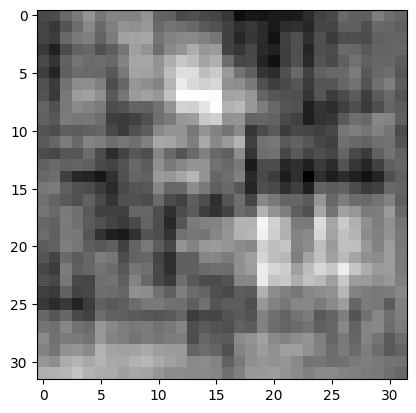

In [18]:
v1 = tf.random.normal([1, 100]) # Случайный вектор
print("Вектор: ", v1.numpy()[0, :10]) # распечатаем первые 10 элементов
_ = plt.imshow(generate_data(v1, gan.generator)[0, ..., 0], cmap='gray') # gan не обучен, получим что-то не понятное

In [19]:
# Подготовим данные.
# 1. Увеличим картинки до 32x32 -- в целях более удобного деления на 2
# 2. Преобразуем яркости из 0..255 в -1..1
# 3. Используя функции tensorflow превратим датасет в итератор по батчам. (раньше за нас это делал Keras)

(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = tf.image.resize(train_images, (32, 32), tf.image.ResizeMethod.NEAREST_NEIGHBOR)

train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)

In [20]:
# создав датасет таким образом, мы можем теперь итерироваться по нему так
for img in train_dataset.take(4):
    print(img.shape) # но он возвращает только одну картинку за раз

(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)


In [21]:
# разобьем его на батчи и перемешаем (BUFFER_SIZE -- параметр перемешивания, обычно равен размеру датасета)
BUFFER_SIZE = 60000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
for img in train_dataset.take(4):
    print(img.shape) # теперь итерирование происходит по батчам

(256, 32, 32, 1)
(256, 32, 32, 1)
(256, 32, 32, 1)
(256, 32, 32, 1)


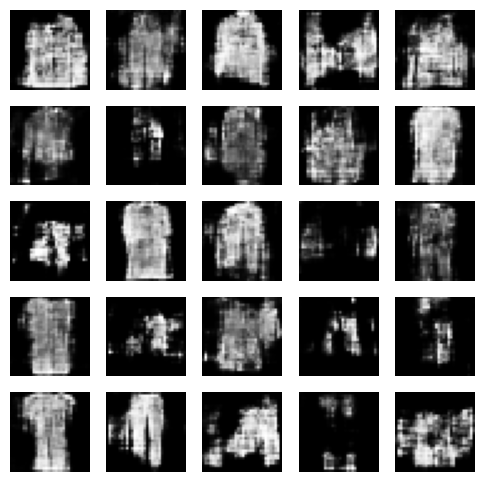

Time for epoch 19 is 50.451865911483765 sec


In [22]:
gan.train(train_dataset, EPOCHS) # занимает около 20 минут, одна эпоха в минуту

In [35]:
###
gan.load_weights("weights/gan2")

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for weights/gan2

In [38]:
import imageio.v2 as imageio
filenames = sorted(list(output.glob("*:*.png")), key=lambda x: int(x.name.split(":")[0].split("_")[1]))
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('movie.gif', images, duration=.2)

# Генерация данных

Вектор:  [-1.3544159   0.7045493   0.03666191  0.86918795  0.43842277 -0.53439844
 -0.07710292  1.5658046  -0.1012345  -0.2744975 ]


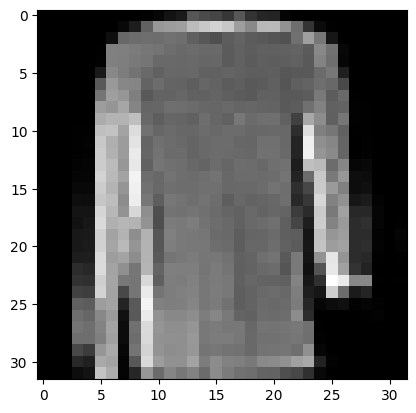

In [45]:
v1 = tf.random.normal([1, 100]) # Случайный вектор
print("Вектор: ", v1.numpy()[0, :10]) # распечатаем первые 10 элементов
_ = plt.imshow(generate_data(v1, gan.generator)[0, ..., 0], cmap='gray') # gan не обучен, получим что-то не понятное

# Интерполяция

Т.к. наши картинки генерируются из векторов, то мы можем производить с ними различные векторные операции. Посчитать среднее: 

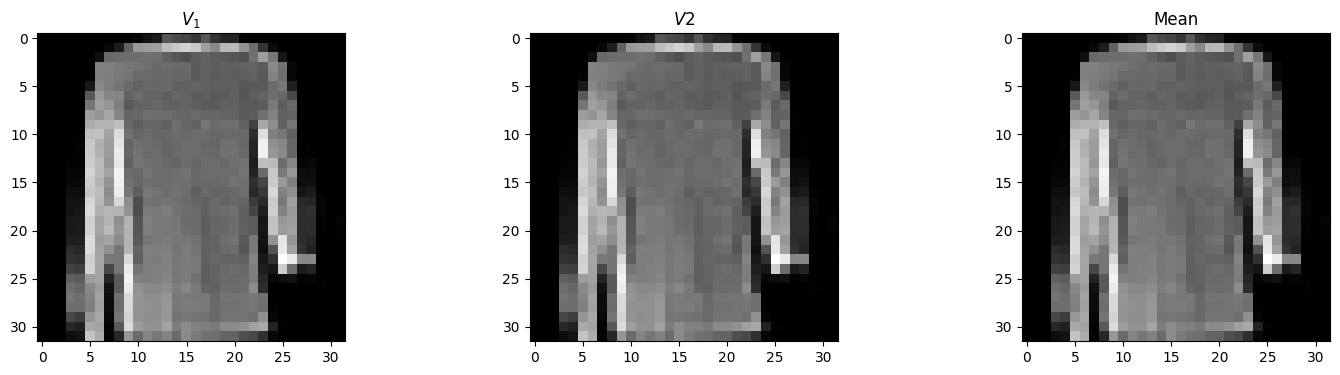

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
v1 = tf.random.normal([1, 100])
v2 = tf.random.normal([1, 100])
mean_vec = (v1+v2)/2.

for ax, vec, name in zip(axs, [v1, v2, mean_vec], ["$V_1$", "$V2$", "Mean"]):
    image = generate_data(vec, gan.generator)[0, ..., 0]
    ax.imshow(image, cmap='gray')
    ax.set_title(name)


Или вместо среднего мы можем "смешать" их в разных пропорциях. Или интерполировать. Т.е. превратить один вектор в другой. А значит и одну картинку в другую!

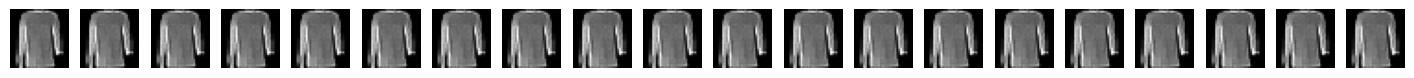

In [46]:
v1 = tf.random.normal([1, 100])
v2 = tf.random.normal([1, 100])

n = 20
fig, axs = plt.subplots(1, n, figsize=(18, 4))
for i, alpha in enumerate(np.linspace(0, 1, n)):
    curr_vec = v1 * (1 - alpha) + v2 * alpha
    image = generate_data(curr_vec, gan.generator)[0, ..., 0]
    axs[i].imshow(image, cmap='gray')
    axs[i].axis('off')